In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from transformers import

import tensorflow as tf
import pprint
import json
import random

sns.set_style("whitegrid")

In [174]:
data_path = "/kaggle/input/ddata-new/data-numpy.npy"
data = np.load(data_path)

In [117]:
data.shape

(2182, 40)

In [118]:
unique = np.unique(data, return_counts=True)

unique = pd.DataFrame(data=unique[1], index=unique[0], columns=["count"]).sort_values(by="count", ascending=False)
unique.head(10)

,count
0,55687
1,9050
537,1622
512,1585
549,1536
517,1268
416,1243
529,1179
488,1175
484,1092


In [180]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(data, test_size=0.15, random_state=133)

In [181]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Parameters
input_shape = (40,)
vocab_size = 555
dropout1_rate = 0.3
dropout2_rate = 0.2
encoder_lstm_units = (64, 32, 16)
decoder_lstm_units = (128, 128)

# Encoder part
encoder_input_layer = Input(shape=input_shape)
encoder_embedding_layer = Embedding(input_dim=vocab_size, output_dim=128)(encoder_input_layer)
# encoder_masking_layer = Masking(mask_value=0)(encoder_embedding_layer)  # NOT COMPATIBLE
encoder_lstm1_layer = LSTM(encoder_lstm_units[0], return_sequences=True, activation='tanh')(encoder_embedding_layer)
encoder_dropout1_layer = Dropout(rate=dropout1_rate)(encoder_lstm1_layer)
encoder_lstm2_layer = LSTM(encoder_lstm_units[1], return_sequences=True, activation='tanh')(encoder_dropout1_layer)
encoder_dropout2_layer = Dropout(rate=dropout2_rate)(encoder_lstm2_layer)
encoder_lstm3_layer = LSTM(encoder_lstm_units[2], return_sequences=True, activation='tanh')(encoder_dropout2_layer)

encoder = Model(encoder_input_layer, encoder_lstm3_layer)



# Decoder part
decoder_input_layer = Input(shape=(input_shape[0], encoder_lstm_units[2]))
decoder_lstm1_layer = LSTM(decoder_lstm_units[0], return_sequences=True, activation='tanh')(decoder_input_layer)
decoder_dropout1_layer = Dropout(rate=dropout2_rate)(decoder_lstm1_layer)
decoder_lstm2_layer = LSTM(decoder_lstm_units[1], return_sequences=True, activation='tanh')(decoder_dropout1_layer)
decoder_dropout2_layer = Dropout(rate=dropout1_rate)(decoder_lstm2_layer)
# decoder_lstm3_layer = LSTM(decoder_lstm_units[2], return_sequences=True, activation='tanh')(decoder_dropout2_layer)
decoder_output_layer = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder_dropout2_layer)

decoder = Model(decoder_input_layer, decoder_output_layer)



# The full Autoencoder
autoencoder = Model(encoder_input_layer, decoder(encoder(encoder_input_layer)))

In [182]:
from tensorflow.keras.utils import register_keras_serializable


# Custom loss to handle masking
@register_keras_serializable()
def masked_sparse_categorical_crossentropy(y_true, y_pred):
    mask1 = tf.not_equal(y_true, 0)
    mask2 = tf.not_equal(y_true, 1)
    mask = tf.cast(tf.math.logical_and(mask1, mask2), tf.float32)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)
    masked_loss = loss * mask
    mask_sum = tf.reduce_sum(mask)
    return tf.cond(
        tf.not_equal(mask_sum, 0),
        lambda: tf.reduce_sum(masked_loss) / mask_sum,
        lambda: tf.constant(0.0, dtype=tf.float32)
    )

# Custom metric to handle masking
@register_keras_serializable()
def masked_sparse_categorical_accuracy(y_true, y_pred):
    mask1 = tf.not_equal(y_true, 0)
    mask2 = tf.not_equal(y_true, 1)
    mask = tf.cast(tf.math.logical_and(mask1, mask2), tf.float32)
    correct_predictions = tf.equal(tf.cast(y_true, tf.int64), tf.argmax(y_pred, axis=-1))
    accuracy = tf.cast(correct_predictions, tf.float32) * mask
    mask_sum = tf.reduce_sum(mask)
    
    return tf.cond(
        tf.not_equal(mask_sum, 0),
        lambda: tf.reduce_sum(accuracy) / mask_sum,
        lambda: tf.constant(0.0, dtype=tf.float32)
    )

In [183]:
# Compile the autoencoder
autoencoder.compile(optimizer=Adam(learning_rate=0.001),
                    loss=masked_sparse_categorical_crossentropy,
                    metrics=[masked_sparse_categorical_accuracy]
                   )

In [184]:
autoencoder.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_18 (Functional)      │ (None, 40, 16)         │       136,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_19 (Functional)      │ (None, 40, 555)        │       277,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 413,419 (1.58 MB)

 Trainable params: 413,419 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [185]:
# Train the autoencoder
early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = autoencoder.fit(X_train, X_train,
                          epochs=120,
                          batch_size=32,
                          validation_data=(X_val, X_val),
                          callbacks=[early_stopping]
                         )

Epoch 1/120
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 5.5485 - masked_sparse_categorical_accuracy: 0.0648 - val_loss: 3.9498 - val_masked_sparse_categorical_accuracy: 0.0653
Epoch 2/120
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 3.9340 - masked_sparse_categorical_accuracy: 0.0720 - val_loss: 3.7276 - val_masked_sparse_categorical_accuracy: 0.1465
Epoch 3/120
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 3.6854 - masked_sparse_categorical_accuracy: 0.1311 - val_loss: 3.5455 - val_masked_sparse_categorical_accuracy: 0.1612
Epoch 4/120
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 3.5490 - masked_sparse_categorical_accuracy: 0.1454 - val_loss: 3.4632 - val_masked_sparse_categorical_accuracy: 0.1797
Epoch 5/120
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 3.4807 - masked_sparse_categorical_accuracy: 0.1557 - val_loss: 3.4193 - val_masked_sparse_categorical_accuracy: 0.1774
Epoch 6/120
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 3.4293 - masked_sparse_categorical_accur

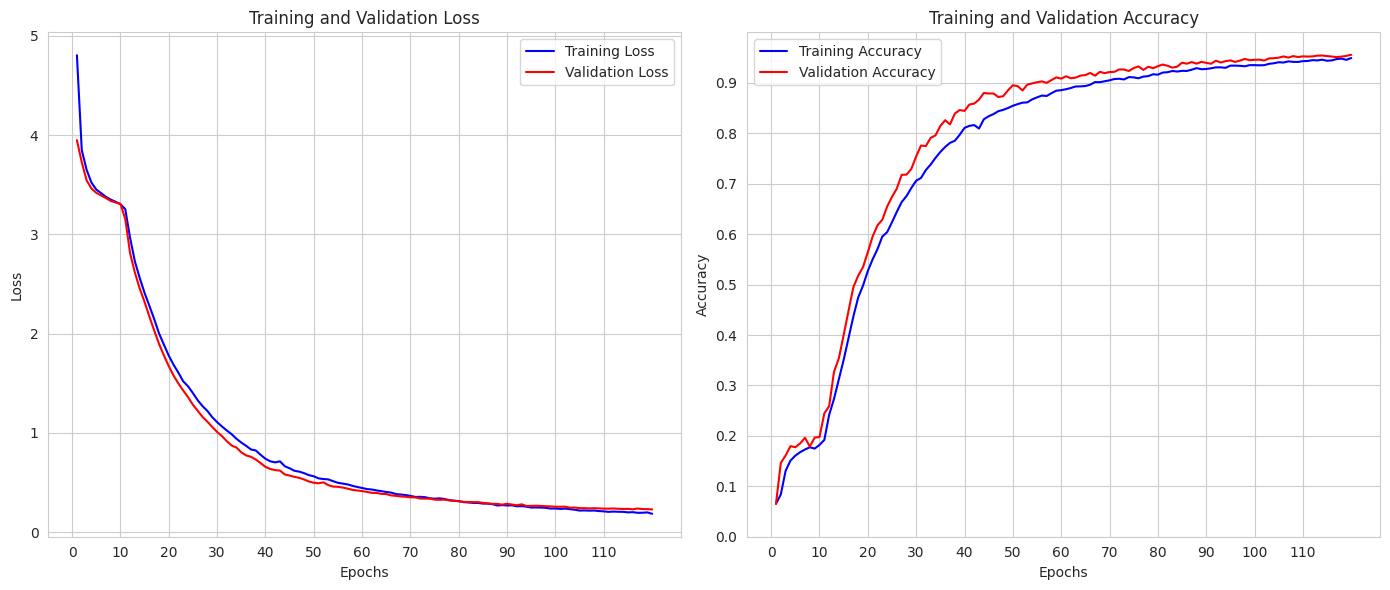

In [186]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['masked_sparse_categorical_accuracy']
validation_accuracy = history.history['val_masked_sparse_categorical_accuracy']


# Number of epochs
epochs = range(1, len(training_loss) + 1)
xticks = np.arange(0, 120, 10)
yticks = np.round(np.arange(0, 1, 0.1), 1)

# Plotting training and validation loss
fig = plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.xticks(ticks=xticks, labels=xticks)
# plt.yticks(ticks=yticks, labels=yticks)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(ticks=xticks, labels=xticks)
plt.yticks(ticks=yticks, labels=yticks)
plt.legend()

plt.tight_layout()
plt.show()

fig.savefig("training-process.png", dpi=100)

#### Saving the best model

In [ ]:
best_tr_acc = int(round(np.max(history.history["masked_sparse_categorical_accuracy"]), 4) * 10000)
best_val_acc = int(round(np.max(history.history["val_masked_sparse_categorical_accuracy"]), 4) * 10000)

autoencoder.save(f"tr_acc_{best_tr_acc}_val_acc_{best_val_acc}.keras")
print(f"saving tr_acc_{best_tr_acc}_val_acc_{best_val_acc}.keras ...")

#### Loading the model

In [124]:
model_path = "/kaggle/working/tr_acc_9742_val_acc_9679.keras"
autoencoder = tf.keras.models.load_model(model_path)

#### Make predictions

In [187]:
autoencoder.evaluate(data, data, batch_size=32)

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1356 - masked_sparse_categorical_accuracy: 0.9698


[0.11382625997066498, 0.9733691215515137]

In [126]:
import re

def pre_process(text):

    text = text.replace("\n", "")
    text = text.lower()
    text = text.strip()
    # text = text.replace(" ", "")

    text = re.sub(r'\s{2,}', ' ', text)
    text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '<EMAIL>', text)
    text = re.sub(r'\b\w+(?:\.\w+)+\b', '<SUB>', text)
    text = re.sub(r'(\d+:)+\d+', '<TIME>', text)
    text = re.sub(r'\d{4}-\d{2}-\d{2}', '<DATE>', text)
    text = re.sub(r'\b(\w+)(?:,\1)+\b', '<SERIES>', text)
    text = re.sub(r'\b\d+(?:,\d+)+\b', '<SERIES>', text)
    text = re.sub(r'\bchar\(\d+(?:\+\d+)*\)', '<SERIES>', text)
    text = re.sub(r'<SERIES>(?:\+<SERIES>)+', '<SERIES>', text)
    text = re.sub(r'\b\d+(?:\.\d+)?\b', '<NUMBER>', text)
    text = re.sub(r'(.)\1{2,}', '<REPETITIVE>', text)
    text = re.sub(r'(?<=[@$%^!~/[\]\\` ])(?!a)\w(?=[@$%^!~/[\]\\` ])', '<SINGLE>', text)

    special_characters = r'[@$%^!~/[\]\-\`]'
    text = re.sub(rf'{special_characters}{{2,}}', '<REGEX>', text)
    text = re.sub(special_characters, '<SPECIAL>', text)

    text = text.replace(",", "")

    return text

In [127]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def encode(query: str, tokenizer) -> list[int]:
    query = pre_process(query)
#     print(query)
    tok = tokenizer.tokenize(query)
#     print(tok)
    tok = list(map(lambda x: x.replace("Ġ", ""), tok))
    tok = [item for item in tok if item != ""]

    for i, t in enumerate(tok):
        if bool(re.fullmatch(r'[a-zA-Z]', t)) or bool(re.fullmatch(r'-?\d+', t)):
            tok[i] = "<oov>"
#     print(tok)

    seq = tokenizer.convert_tokens_to_ids(tok)
#     print(seq)
    seq = [item for item in seq if item != None]
    act_len = np.min([len(seq), 40])
    seq = pad_sequences(sequences=[seq],
                        maxlen=40,
                        padding="post",
                        truncating="post")
    return seq[0]

In [128]:
def predict_from_sentence(sentences: list[str], tokenizer, model):
    y_true = encode(sentences[0], tokenizer).reshape((1, 40))
    for s in sentences[1:]:
        s_encoded = encode(s, tokenizer)
        y_true = np.append(y_true, s_encoded.reshape((1, 40)), axis=0)

    y_pred = model.predict(y_true, batch_size=1)
    proba = masked_sparse_categorical_accuracy(y_true, y_pred)

    return y_true, y_pred, proba

In [129]:
from transformers import GPT2Tokenizer
vocab = "/kaggle/input/my-nre-vocab/vocab/vocab.json"
merges = "/kaggle/input/my-nre-vocab/vocab/merges.txt"
tokenizer = GPT2Tokenizer(vocab_file=vocab, merges_file=merges)


placeholders = ["<EMAIL>", "<SUB>", "<TIME>", "<DATE>", "<SERIES>", "<NUMBER>", "<REPETITIVE>", "<SINGLE>", "<REGEX>", "<SPECIAL>"]
special_tokens_dict = {'additional_special_tokens': placeholders}
tokenizer.add_special_tokens(special_tokens_dict)

0

In [130]:
sql_queries = [
    "SELECT * FROM Customers;",
    "SELECT FirstName, LastName FROM Employees;",
    "SELECT COUNT(*) FROM Orders;",
    "SELECT DISTINCT City FROM Customers;",
    "SELECT MAX(OrderAmount) FROM Orders;",
    "SELECT AVG(Price) FROM Products;",
    "SELECT * FROM Products WHERE Price > 100;",
    "SELECT * FROM Orders WHERE OrderDate BETWEEN '2022-01-01' AND '2022-12-31';",
    "SELECT * FROM Employees ORDER BY LastName;",
    "SELECT * FROM Customers LIMIT 10 OFFSET 5;",

    "SELECT Customers.FirstName, Orders.OrderAmount FROM Customers JOIN Orders ON Customers.CustomerID = Orders.CustomerID;",
    "SELECT Employees.FirstName, Departments.DepartmentName FROM Employees LEFT JOIN Departments ON Employees.DepartmentID = Departments.DepartmentID;",
    "SELECT Products.ProductName, Categories.CategoryName FROM Products INNER JOIN Categories ON Products.CategoryID = Categories.CategoryID;",
    "SELECT Orders.OrderID, Customers.FirstName FROM Orders RIGHT JOIN Customers ON Orders.CustomerID = Customers.CustomerID;",
    "SELECT Employees.FirstName, COUNT(Orders.OrderID) FROM Employees LEFT JOIN Orders ON Employees.EmployeeID = Orders.EmployeeID GROUP BY Employees.FirstName;",

    "INSERT INTO Customers (FirstName, LastName, City) VALUES ('John', 'Doe', 'New York');",
    "INSERT INTO Products (ProductName, Price) VALUES ('Widget', 19.99);",
    "INSERT INTO Orders (CustomerID, OrderDate, OrderAmount) VALUES (1, '2023-08-01', 250.00);",
    "INSERT INTO Employees (FirstName, LastName, DepartmentID) VALUES ('Jane', 'Smith', 2);",
    "INSERT INTO Departments (DepartmentName) VALUES ('Sales');",

    "UPDATE Customers SET City = 'Los Angeles' WHERE CustomerID = 1;",
    "UPDATE Products SET Price = Price * 1.10 WHERE ProductName = 'Widget';",
    "UPDATE Orders SET OrderAmount = 300.00 WHERE OrderID = 5;",
    "UPDATE Employees SET DepartmentID = 3 WHERE EmployeeID = 2;",
    "UPDATE Departments SET DepartmentName = 'Marketing' WHERE DepartmentID = 1;",

    "DELETE FROM Orders WHERE OrderDate < '2022-01-01';",
    "DELETE FROM Customers WHERE CustomerID = 10;",
    "DELETE FROM Products WHERE Price < 5.00;",
    "DELETE FROM Employees WHERE LastName = 'Smith';",
    "DELETE FROM Departments WHERE DepartmentID = 4;",

    "CREATE TABLE Customers (CustomerID INT PRIMARY KEY, FirstName VARCHAR(50), LastName VARCHAR(50), City VARCHAR(50));",
    "CREATE TABLE Products (ProductID INT PRIMARY KEY, ProductName VARCHAR(100), Price DECIMAL(10, 2));",
    "CREATE TABLE Orders (OrderID INT PRIMARY KEY, CustomerID INT, OrderDate DATE, OrderAmount DECIMAL(10, 2), FOREIGN KEY (CustomerID) REFERENCES Customers(CustomerID));",
    "CREATE TABLE Employees (EmployeeID INT PRIMARY KEY, FirstName VARCHAR(50), LastName VARCHAR(50), DepartmentID INT);",
    "CREATE TABLE Departments (DepartmentID INT PRIMARY KEY, DepartmentName VARCHAR(50));",

    "ALTER TABLE Customers ADD COLUMN Email VARCHAR(100);",
    "ALTER TABLE Products MODIFY COLUMN Price DECIMAL(12, 2);",
    "ALTER TABLE Orders DROP COLUMN OrderAmount;",
    "ALTER TABLE Employees ADD FOREIGN KEY (DepartmentID) REFERENCES Departments(DepartmentID);",
    "ALTER TABLE Departments RENAME TO Dept;",

    "SELECT * FROM Customers WHERE City LIKE 'New%';",
    "SELECT * FROM Products WHERE ProductName IN ('Widget', 'Gadget');",
    "SELECT * FROM Orders WHERE OrderAmount BETWEEN 100 AND 500;",
    "SELECT * FROM Employees WHERE LastName IS NOT NULL;",
    "SELECT * FROM Customers ORDER BY City DESC;",

    "SELECT Employees.FirstName, SUM(Orders.OrderAmount) FROM Employees JOIN Orders ON Employees.EmployeeID = Orders.EmployeeID GROUP BY Employees.FirstName;",
    "SELECT COUNT(DISTINCT City) FROM Customers;",
    "SELECT Products.ProductName, SUM(Orders.OrderAmount) FROM Products LEFT JOIN Orders ON Products.ProductID = Orders.ProductID GROUP BY Products.ProductName;",
    "SELECT Customers.FirstName, COUNT(Orders.OrderID) FROM Customers LEFT JOIN Orders ON Customers.CustomerID = Orders.CustomerID GROUP BY Customers.FirstName;",
    "SELECT * FROM Orders WHERE CustomerID IN (SELECT CustomerID FROM Customers WHERE City = 'New York');",

    "SELECT * FROM Products WHERE Price = (SELECT MAX(Price) FROM Products);",
    "SELECT * FROM Orders WHERE OrderID = (SELECT MIN(OrderID) FROM Orders);",
    "SELECT * FROM Employees WHERE EmployeeID IN (1, 2, 3);",
    "SELECT * FROM Customers WHERE CustomerID NOT IN (SELECT CustomerID FROM Orders);",
    "SELECT * FROM Employees WHERE DepartmentID = (SELECT DepartmentID FROM Departments WHERE DepartmentName = 'Sales');",

    "INSERT INTO Customers (FirstName, LastName, City) VALUES ('Alice', 'Johnson', 'Chicago');",
    "INSERT INTO Products (ProductName, Price) VALUES ('Gadget', 29.99);",
    "INSERT INTO Orders (CustomerID, OrderDate, OrderAmount) VALUES (2, '2023-08-02', 150.00);",
    "INSERT INTO Employees (FirstName, LastName, DepartmentID) VALUES ('Bob', 'Brown', 1);",
    "INSERT INTO Departments (DepartmentName) VALUES ('HR');",

    "UPDATE Customers SET City = 'San Francisco' WHERE CustomerID = 2;",
    "UPDATE Products SET Price = Price * 0.90 WHERE ProductName = 'Gadget';",
    "UPDATE Orders SET OrderAmount = 400.00 WHERE OrderID = 3;",
    "UPDATE Employees SET DepartmentID = 1 WHERE EmployeeID = 3;",
    "UPDATE Departments SET DepartmentName = 'Finance' WHERE DepartmentID = 2;",

    "DELETE FROM Orders WHERE OrderID = 7;",
    "DELETE FROM Customers WHERE LastName = 'Doe';",
    "DELETE FROM Products WHERE ProductID = 1;",
    "DELETE FROM Employees WHERE EmployeeID = 5;",
    "DELETE FROM Departments WHERE DepartmentName = 'HR';",

    "CREATE TABLE Suppliers (SupplierID INT PRIMARY KEY, SupplierName VARCHAR(100));",
    "CREATE TABLE Inventory (ProductID INT, Quantity INT, FOREIGN KEY (ProductID) REFERENCES Products(ProductID));",
    "CREATE TABLE Sales (SaleID INT PRIMARY KEY, ProductID INT, SaleDate DATE, SaleAmount DECIMAL(10, 2), FOREIGN KEY (ProductID) REFERENCES Products(ProductID));",
    "CREATE TABLE Customers (CustomerID INT PRIMARY KEY, FirstName VARCHAR(50), LastName VARCHAR(50), Email VARCHAR(100));",
    "CREATE TABLE Employees (EmployeeID INT PRIMARY KEY, FirstName VARCHAR(50), LastName VARCHAR(50), Email VARCHAR(100));",

    "ALTER TABLE Suppliers ADD COLUMN ContactName VARCHAR(50);",
    "ALTER TABLE Inventory ADD COLUMN LastUpdated TIMESTAMP DEFAULT CURRENT_TIMESTAMP;",
    "ALTER TABLE Sales ADD COLUMN Discount DECIMAL(5, 2);",
    "ALTER TABLE Customers RENAME COLUMN Email TO ContactEmail;",
    "ALTER TABLE Employees DROP COLUMN Email;",

    "SELECT * FROM Suppliers;",
    "SELECT SupplierName FROM Suppliers WHERE SupplierID = 1;",
    "SELECT COUNT(*) FROM Inventory;",
    "SELECT * FROM Sales WHERE SaleDate >= '2023-01-01';",
    "SELECT SUM(Quantity) FROM Inventory WHERE ProductID = 1;",

    "SELECT Products.ProductName, Inventory.Quantity FROM Products JOIN Inventory ON Products.ProductID = Inventory.ProductID;",
    "SELECT Suppliers.SupplierName, COUNT(Products.ProductID) FROM Suppliers LEFT JOIN Products ON Suppliers.SupplierID = Products.SupplierID GROUP BY Suppliers.SupplierName;",
    "SELECT Sales.SaleID, Products.ProductName FROM Sales JOIN Products ON Sales.ProductID = Products.ProductID;",
    "SELECT Employees.FirstName, COUNT(Sales.SaleID) FROM Employees LEFT JOIN Sales ON Employees.EmployeeID = Sales.EmployeeID GROUP BY Employees.FirstName;",
    "SELECT * FROM Suppliers WHERE SupplierName LIKE 'A%';"
]


In [131]:
normal_text = [
    "The quick brown fox jumps over the lazy dog.",
    "Artificial intelligence is transforming industries around the world.",
    "The weather today is sunny with a slight chance of rain.",
    "Python is a versatile programming language widely used in data science.",
    "Machine learning algorithms can make predictions based on data.",
    "Reading books can expand your knowledge and imagination.",
    "Traveling to new places provides valuable life experiences.",
    "Healthy eating habits contribute to overall well-being.",
    "Music has the power to evoke strong emotions and memories.",
    "The internet has revolutionized how we communicate and access information."
]


In [132]:
custom = ["select name from server where 1=1;"]

In [188]:
y_true, y_pred, proba = predict_from_sentence(sql_queries, tokenizer, autoencoder)


print(f"prediction: {proba}")
print("="*80)
print(f"true: {y_true[0]}")
print("="*80)
print(f"pred: {np.argmax(y_pred[0], axis=-1)}")


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
prediction: 0.9150623083114624
true: [484 516 416   1 526   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]
pred: [484 516 416 498 526 478 478 478 478 478 526 526 526 526 526 526 526 526
 526 526 526 526 526 526 526 526 526 526 526 526 526 526 526 526 526 526
 526 526 526 526]


# Model Studying and testing

## 1. using training data

In [134]:
y_train_pred = autoencoder.predict(data, batch_size=32)
probas = np.array([masked_sparse_categorical_accuracy(yt, yp).numpy() for yt, yp in zip(data, y_train_pred)])

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


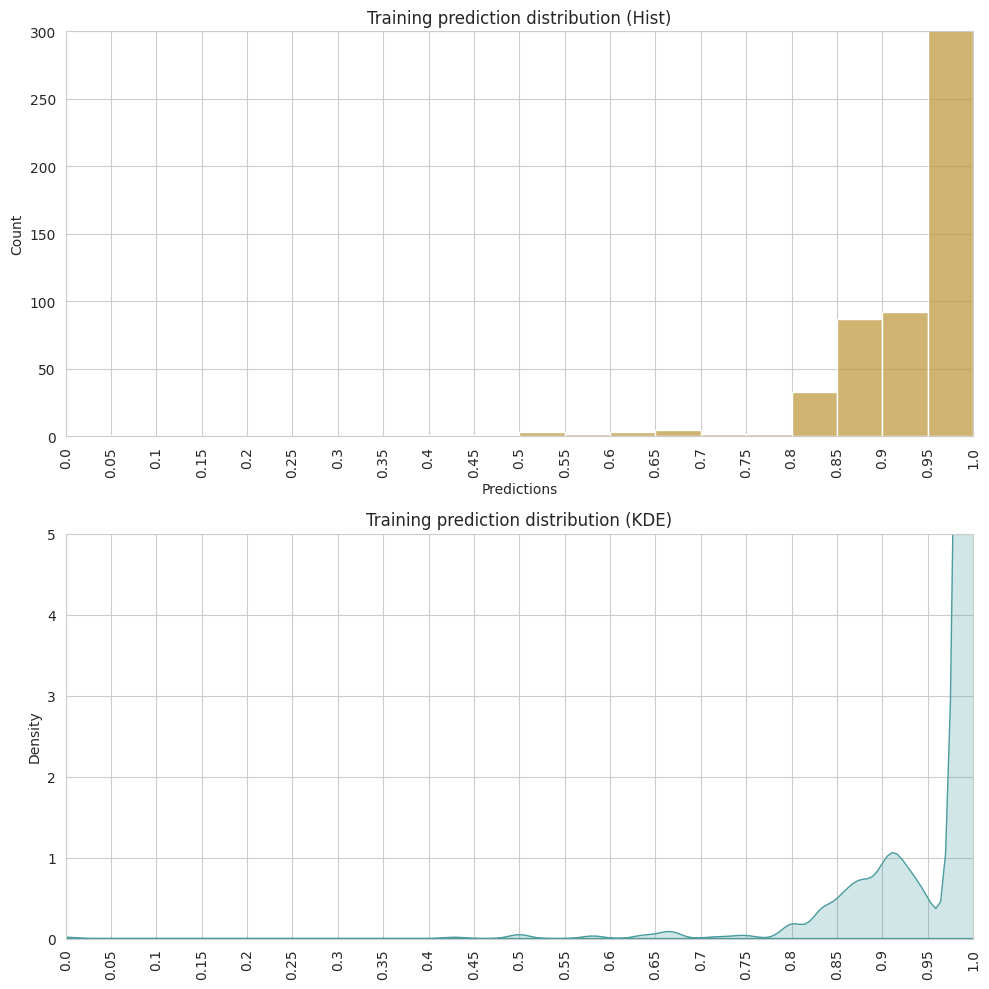

In [135]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ticks = np.round(np.arange(0, 1.05, 0.05), 2)

sns.histplot(data=probas, bins=ticks, ax=ax[0], color="#BF9A40")
ax[0].set_title("Training prediction distribution (Hist)")
ax[0].set_xlabel("Predictions")
ax[0].set_xticks(ticks=ticks, labels=ticks, rotation=90)
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 300)


sns.kdeplot(data=probas, fill=True, ax=ax[1], color="#4A9C9E")
ax[1].set_title("Training prediction distribution (KDE)")
ax[0].set_xlabel("Predictions")
ax[1].set_xticks(ticks=ticks, labels=ticks, rotation=90)
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 5)



plt.tight_layout()
plt.show()
fig.savefig("training-prediction-distribution-analysis.png")

**REMARK:** some predictions are bad, in fact those queries has predictions under 0.5 which is abnormal!

In [136]:
criteria = 0.6

print(f"predictions under {criteria}: ", probas[np.where(probas<criteria)[0]])
print("their indexes: ", np.where(probas<criteria)[0])
print(f"ratio of prediction under {criteria}: ", np.where(probas<criteria)[0].shape[0] / data.shape[0])

predictions under 0.6:  [0.5833333  0.5        0.57894737 0.42857143 0.5        0.
 0.5       ]
their indexes:  [ 128  140  283  390  669  796 2061]
ratio of prediction under 0.6:  0.0032080659945004585


- the ratio of those bad predictions over the entier dataset is very small, in fact those bad predictions are some unusual queries or even non-valid queries at all, so we can ignore them.

## 2. using benchmark data
- Using custom benchmark data that have some criterias ...

#### 1. Simple EDA of the overall data

In [189]:
with open("/kaggle/input/test-bench/test.json", "r") as f:
    test_data = json.load(f)
    test_df = pd.DataFrame(test_data)
    test_df = test_df.sample(frac=1).reset_index(drop=True)

display(test_df.head())
print(f"\n- number of test instances: {test_df.shape[0]} instances\n")
print(test_df.value_counts("label"))

,content,type,label
0,The HAVING fun at the carnival was unforgettable.,texts with sql keywords,0
1,"""))) AND (SELECT LENGTH(password) FROM users W...",sql injections,1
2,Where can I find the missing documents in the ...,sql-like normal text,0
3,The AVG temperature this week has been quite p...,texts with sql keywords,0
4,John Smith is a software engineer with over 10...,random input,0



- number of test instances: 520 instances

label
0    295
1    225
Name: count, dtype: int64


**Columns Explanation**

**1. content:** the input text

**2. type:** type of the benchmark test data

**3. label:** whether it is a an SQL or not
- **`0`** means "normal input"
- **`1`** means "sql query"

In [191]:
y_true, y_pred, _ = predict_from_sentence(test_df["content"], tokenizer, autoencoder)
test_df["prediction"] = [masked_sparse_categorical_accuracy(yt, yp).numpy() for yt, yp in zip(y_true, y_pred)]

test_df.head(10)

520/520 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


,content,type,label,prediction
0,The HAVING fun at the carnival was unforgettable.,texts with sql keywords,0,0.000000
1,"""))) AND (SELECT LENGTH(password) FROM users W...",sql injections,1,0.875000
2,Where can I find the missing documents in the ...,sql-like normal text,0,0.333333
3,The AVG temperature this week has been quite p...,texts with sql keywords,0,0.000000
4,John Smith is a software engineer with over 10...,random input,0,0.142857
5,I want to create a stored procedure for repeti...,texts with sql keywords,0,0.000000
6,"' UNION SELECT 1, 2, 3; --",sql injections,1,0.875000
7,' OR (SELECT 1 FROM users WHERE username = 'ad...,sql injections,1,0.733333
8,25% off on next purchase,potential SAGE ERP inputs,0,0.200000
9,The connection string specifies the details fo...,texts with sql keywords,0,0.000000


In [139]:
pred1_stats = test_df[test_df["label"] == 1]["prediction"].describe()
pred0_stats = test_df[test_df["label"] == 0]["prediction"].describe()
prediction_statistics = pd.DataFrame(data=[pred1_stats, pred0_stats], index=["Prediction: 1", "Prediction : 0"])
prediction_statistics

,count,mean,std,min,25%,50%,75%,max
Prediction: 1,225.0,0.812258,0.179768,0.125,0.722222,0.857143,0.961538,1.0
Prediction : 0,295.0,0.144287,0.207873,0.000,0.000000,0.000000,0.250000,1.0


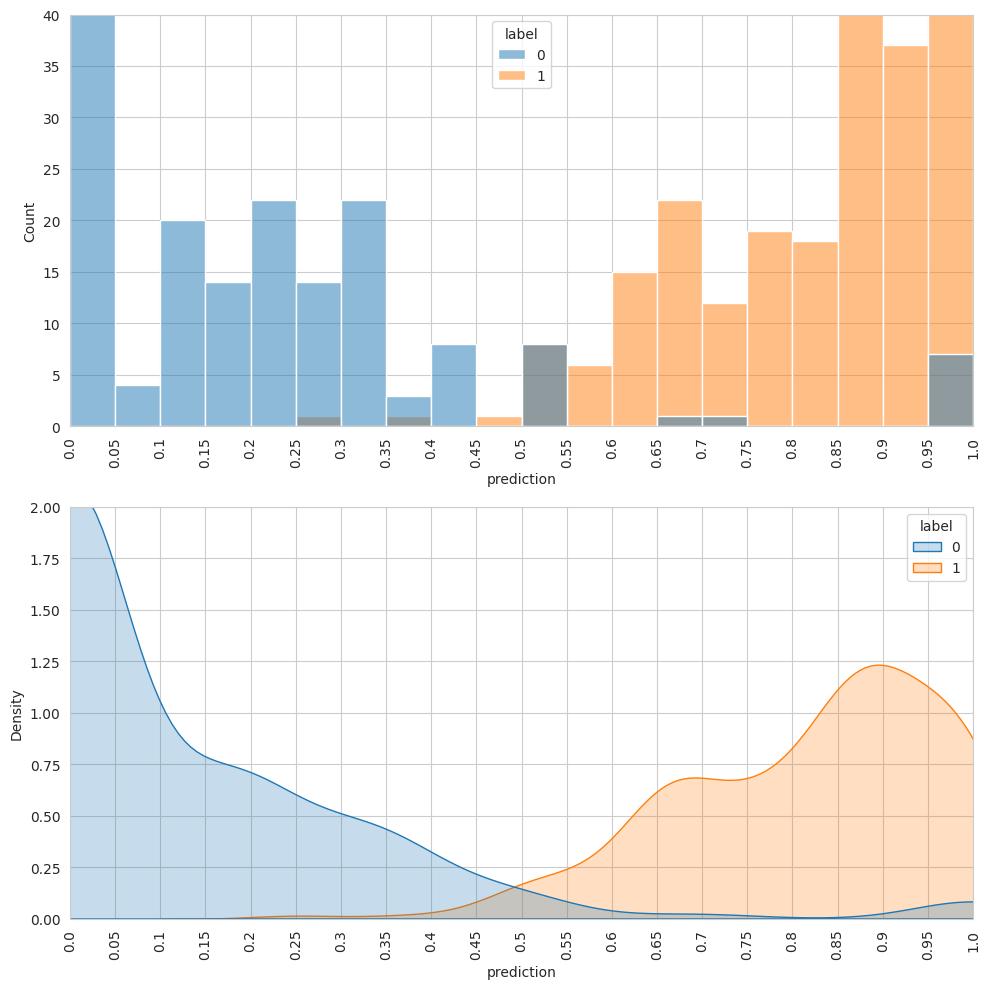

In [192]:
import warnings
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ticks = np.round(np.arange(0, 1.05, 0.05), 2)

sns.histplot(data=test_df, x="prediction", hue="label", bins=ticks, ax=ax[0])
sns.kdeplot(data=test_df, x="prediction", hue="label", fill=True, ax=ax[1])

ax[0].set_xticks(ticks=ticks, labels=ticks, rotation=90)
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 40)

ax[1].set_xticks(ticks=ticks, labels=ticks, rotation=90)
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 2)
    
plt.tight_layout()
plt.show()

fig.savefig("prediction-distribution-analysis.png")

- It's clear the the predictions distribution of each label are skewed (left skewed in the label 0 since it is non-sql input, and right skewed in the label 1 since it is sql input). However they do not look as far one from another as we need.

- The goal is to make the two classes as far one from the other as possible, and set a **theshold** that separate them, this threshold is the value that decide the final prediction, for that we can think of some solutions, such as:
    - augment the training data, since we are currently trin on limited set of data.
    - enhance the vocabulary by removing unwanted and rare keywords, and try other pre-trained tokenizers.
    - play with the model parameters to find the optimal ones.

#### Choosing the prediction threshold

- Lets try an initial value, set it to **t=0.4**

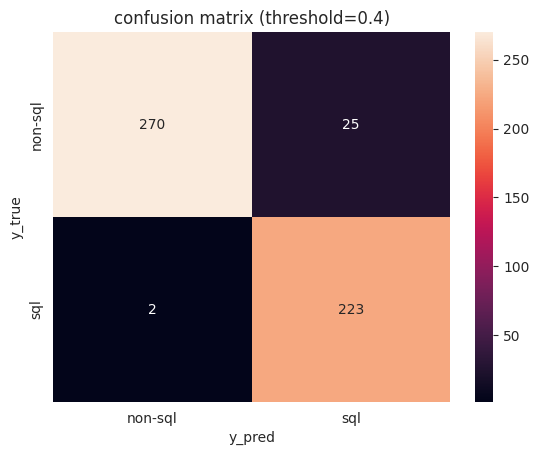

In [193]:
from sklearn.metrics import confusion_matrix

def make_prediction(proba, threshold=None):
    if threshold:
        return int(proba >= threshold)

threshold = 0.4
test_df["pred_label"] = test_df["prediction"].apply(lambda x: make_prediction(x, threshold))
confusion_matrix = confusion_matrix(test_df["label"], test_df["pred_label"])

hm_fig, hm_ax = plt.subplots(dpi=100)
sns.heatmap(confusion_matrix, annot=True, fmt="g", ax=hm_ax, xticklabels=["non-sql", "sql"], yticklabels=["non-sql", "sql"])
hm_ax.set_xlabel("y_pred")
hm_ax.set_ylabel("y_true")
hm_ax.set_title(f"confusion matrix (threshold={threshold})")

plt.show()
hm_fig.savefig("confution-matrix.png")

#### Finding the best threshold

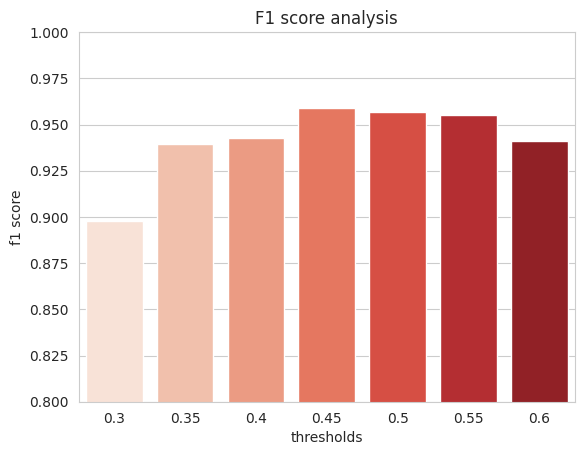

Best threshold:  0.45


In [196]:
from sklearn.metrics import f1_score

thresholds = np.round(np.arange(0.3, 0.65, 0.05), 2)
f1_scores = []
for t in thresholds:
    y_pred = test_df["prediction"].apply(lambda x: make_prediction(x, t))
    score = f1_score(test_df["label"], y_pred)
    f1_scores.append(score)
    
sns.barplot(x=thresholds, y=f1_scores, palette="Reds")
plt.title("F1 score analysis")
plt.xlabel("thresholds")
plt.ylabel("f1 score")
plt.ylim(0.8, 1)

plt.savefig("f1-score-analysis.png")
plt.show()

best_threshold = thresholds[np.argmax(f1_scores)]
print("Best threshold: ", best_threshold)

In [197]:
test_df["pred_label"] = test_df["prediction"].apply(lambda x: make_prediction(x, best_threshold))
test_df.head(10)

,content,type,label,prediction,pred_label
0,The HAVING fun at the carnival was unforgettable.,texts with sql keywords,0,0.000000,0
1,"""))) AND (SELECT LENGTH(password) FROM users W...",sql injections,1,0.875000,1
2,Where can I find the missing documents in the ...,sql-like normal text,0,0.333333,0
3,The AVG temperature this week has been quite p...,texts with sql keywords,0,0.000000,0
4,John Smith is a software engineer with over 10...,random input,0,0.142857,0
5,I want to create a stored procedure for repeti...,texts with sql keywords,0,0.000000,0
6,"' UNION SELECT 1, 2, 3; --",sql injections,1,0.875000,1
7,' OR (SELECT 1 FROM users WHERE username = 'ad...,sql injections,1,0.733333,1
8,25% off on next purchase,potential SAGE ERP inputs,0,0.200000,0
9,The connection string specifies the details fo...,texts with sql keywords,0,0.000000,0


#### 2. Prediction Analysis over each benchmart type

In [145]:
benchmark_types = test_df["type"].unique()
print(benchmark_types)

['sql-like normal text' 'texts with sql keywords' 'random input'
 'general sql queries' 'complex sql queries' 'sql injections'
 'sql queries with complex non-keywords' 'potential SAGE ERP inputs'
 'general sentences']


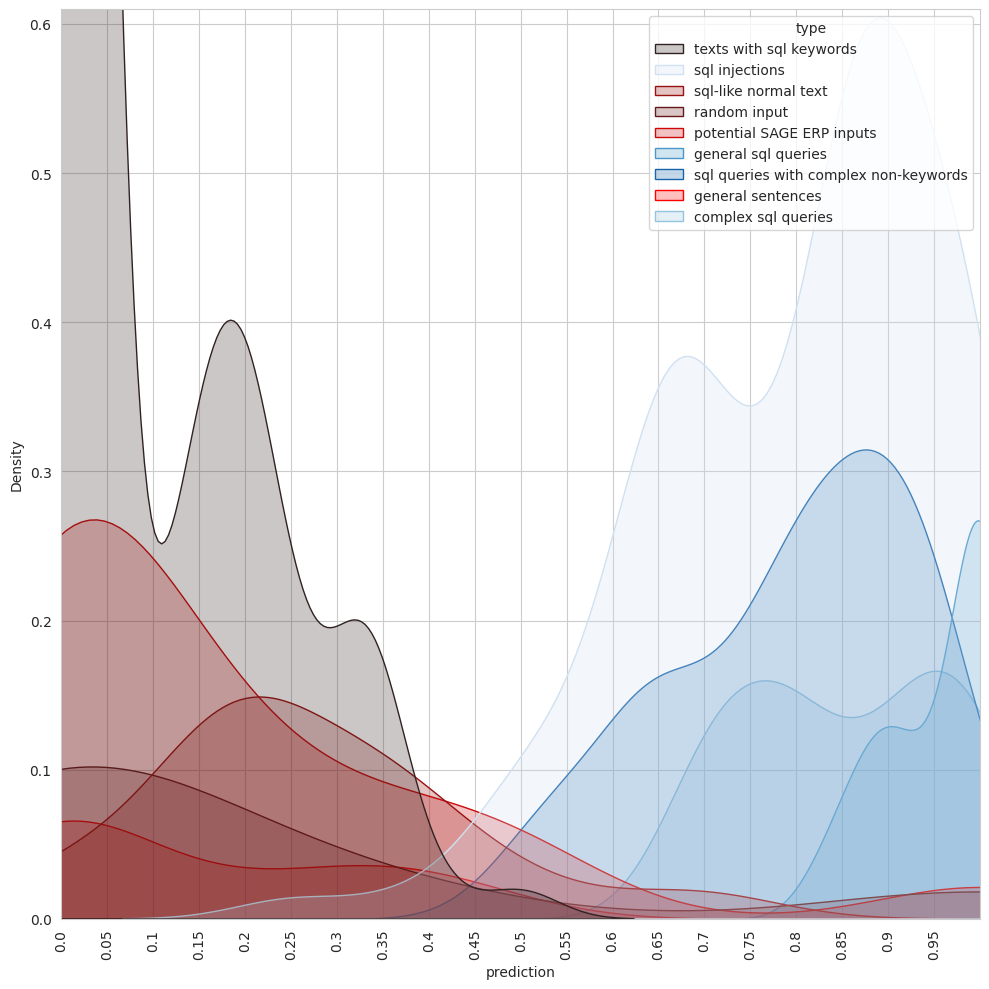

In [198]:
label0 = ['texts with sql keywords', 'random input','sql-like normal text', 'potential SAGE ERP inputs', 'general sentences']
label1 = ['sql injections', 'complex sql queries', 'general sql queries', 'sql queries with complex non-keywords',]
color_palette_label0 = sns.color_palette("dark:red", len(label0))
color_palette_label1 = sns.color_palette("Blues", len(label1))
color_palette = {label: color_palette_label0[i] for i, label in enumerate(label0)}
color_palette.update({label: color_palette_label1[i] for i, label in enumerate(label1)})


fig2, ax2 = plt.subplots(figsize=(10, 10))
ticks = np.round(np.arange(0, 1, 0.05), 2)

sns.kdeplot(data=test_df, x="prediction", hue="type", fill=True, ax=ax2, palette=color_palette)
ax2.set_xticks(ticks=ticks, labels=ticks, rotation=90)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, .61)


plt.tight_layout()
plt.show()

fig2.savefig("prediction-distribution-by-benchmark-types.png")

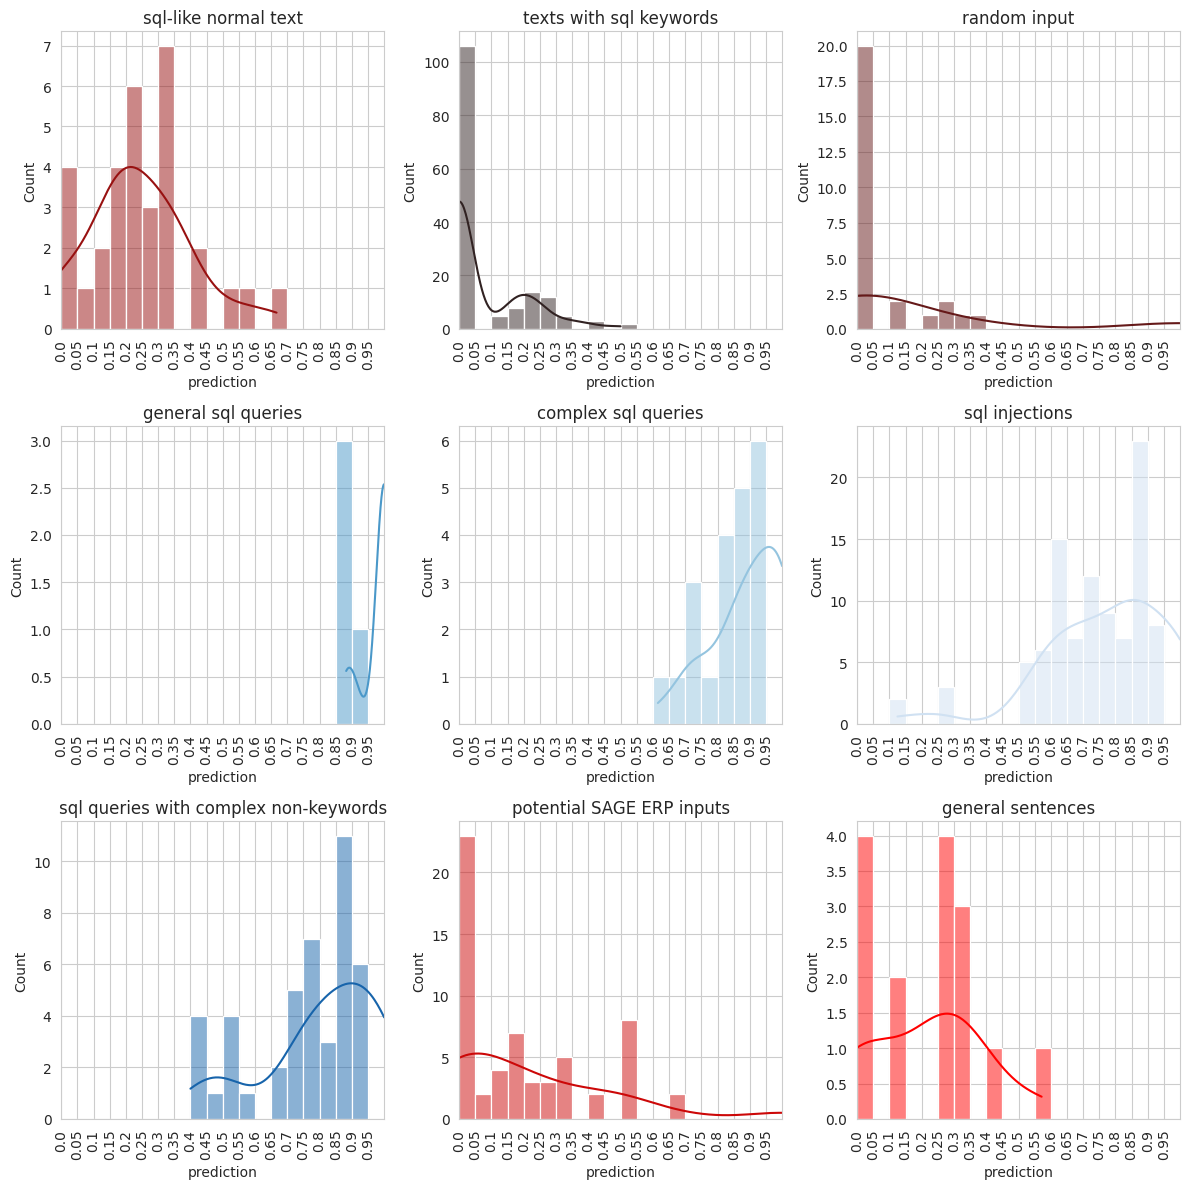

In [147]:
fig3, ax3 = plt.subplots(3, 3, figsize=(12, 12))

for i, benchmark in enumerate(benchmark_types):
    data = test_df[test_df["type"] == benchmark]
    act_ax = ax3[i//3, i%3]
    sns.histplot(data=data, x="prediction", fill=True, bins=ticks, kde=True, ax=act_ax, color=color_palette[benchmark])
    act_ax.set_title(benchmark)
    act_ax.set_xticks(ticks=ticks, labels=ticks, rotation=90)
    act_ax.set_xlim(0, 1)
#     ax2.set_ylim(0, .61)


plt.tight_layout()
plt.show()

fig3.savefig("benchmark-analysis.png")

In [199]:
pd.pivot_table(test_df, values="prediction", index="type", aggfunc=['mean', 'median', 'std']).sort_values(("mean", "prediction"), ascending=False)

,mean,median,std
,prediction,prediction,prediction
type,,,
general sql queries,0.954924,1.000000,0.058748
complex sql queries,0.853705,0.842105,0.110248
sql injections,0.804941,0.857143,0.158425
sql queries with complex non-keywords,0.795963,0.826087,0.132952
sql-like normal text,0.269125,0.225000,0.169373
random input,0.192588,0.000000,0.336614
potential SAGE ERP inputs,0.173656,0.083916,0.248674
general sentences,0.142302,0.000000,0.173839


In [200]:
benchmarks_pivot = test_df.pivot_table(index="type", columns="pred_label", aggfunc={"pred_label": "count"}, fill_value=0)
benchmarks_pivot = benchmarks_pivot.rename(columns={0: "0 predictedt", 1: "1 predicted"})
benchmarks_pivot

pred_label            
pred_label                            0 predictedt 1 predicted
type                                                          
complex sql queries                              0          31
general sentences                               15           0
general sql queries                              0          19
potential SAGE ERP inputs                       54           8
random input                                    27           4
sql injections                                   2         116
sql queries with complex non-keywords            0          57
sql-like normal text                            28           4
texts with sql keywords                        154           1

- The results look good in most benchmark types, except the type "potential SAGE ERP inputs" where the number of "false negatives" is high (13 over 62 in total)
- As a solution we can take alook at the test data from the txt file and see what makes it predicting "false negatives"

#### 1. Benchmark of type "random input"

In [162]:
random_input = test_df[test_df["type"] == "random input"]
random_input["prediction"].describe().T

count    31.000000
mean      0.183820
std       0.337376
min       0.000000
25%       0.000000
50%       0.000000
75%       0.236111
max       1.000000
Name: prediction, dtype: float64

In [201]:
random_input[random_input["prediction"] >= threshold]

,content,type,label,prediction,pred_label
2,9876543210,random input,0,1.0,1
248,2024,random input,0,1.0,1
264,1500,random input,0,1.0,1
397,123456,random input,0,1.0,1


PROBLEM! the model detect number inputs as sql, but why?
Since the numbers are replaced with the placeholder <NUMBER> and this placeholders is actualy a token in the vocabulary the have the id 512. the model is well reconstructing the number input. What should we do?

#### 2. Benchmark of type "complex sql queries"

In [ ]:
complex_sql_queries = test_df[test_df["type"] == "complex sql queries"]
complex_sql_queries["prediction"].describe().T

In [ ]:
bad_predictions = complex_sql_queries[complex_sql_queries["prediction"] <= 0.4]["content"]
print(bad_predictions)

In [ ]:
list(bad_predictions)[0]

In [ ]:
encode(list(bad_predictions)[0], tokenizer)

I looks like the model is having trouble well predicting those inputs, even though they are clearly sql queies!

#### 3. Benchmark of type ""

#### 4. Benchmark of type ""

#### 5. Benchmark of type ""

#### 6. Benchmark of type ""

#### 7. Benchmark of type ""

#### 8. Benchmark of type ""

#### 9. Benchmark of type ""

## Test using sparse categorical cross-entropy

In [ ]:
y_true, y_pred, _ = predict_from_sentence(test_df["content"], tokenizer, autoencoder)
test_df["loss"] = [masked_sparse_categorical_crossentropy(yt, yp).numpy() for yt, yp in zip(y_true, y_pred)]

test_df.head(10)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
bins = np.arange(0, 16, 1)

sns.histplot(data=test_df, x="loss", bins=bins, hue="label", ax=ax[0])
sns.kdeplot(data=test_df, x="loss", hue="label", fill=True, ax=ax[1])

ax[0].set_xticks(ticks=bins, labels=bins)
ax[0].set_ylim(0, 60)
ax[0].set_xlim(0, 16)
ax[1].set_xticks(ticks=bins, labels=bins)
ax[1].set_xlim(0, 16)
ax[1].set_ylim(0, 0.15)
    
plt.tight_layout()
plt.show()

fig.savefig("prediction-distribution-analysis.png")